# Normalizing Flux of Tau Ceti Using NEID Data


## This is what I'm supposed to do: 

In another notebook, we successfully normalzied Tau Ceti for a given order of the wavelength data. Now, the objective is to normalize the entire data set to achieve the average PSF value for the entire data set. Doing so will require there to be easy function calling to accomplish this instead of running this notebook multiple times. 


## Current Issues:

1. normalization of book-end orders are not normalizing at 1, but closer to 0 and then shift up to 1 after a few orders -- unsure how to exactly fix this issue, but will ask on monday and try to produce a histogram
> thinking that perhaps the threshold should be based off of percentile values, like 95th percentile for maxima? will have to try it

## Importing Libraries:


In [1]:
#importing recommended libraries: 

from astropy.io import fits
import matplotlib.pylab as plt
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep

In [2]:
import seaborn as sns
sns.set_theme()

import pandas as pd

## Data set source:

use the following link: 

<https://neid.ipac.caltech.edu/search.php>

if it doesnt do it automatically, the object is HD 10700 and the data level is 1 

>The wavelength range Im looking for is pretty small, but somwhere with 5700 to 5900 angstroms is plenty to account for doppler shift

In [3]:
#reading in data and assigning it to arrays 
#for windows, the path needs double backslashes when copying as a location

star = 'HD 10700' 
data_path = "C:\\Users\\alica\\workspace\\Intro-2-Spectra\\analysis\\NEID_analysis\\neidL1_20220118T015112.fits"
# APF_flux_path = '/datag/blpd0/datax/apf/rarj.224.fits'

file = fits.open(data_path)
# fl_file = fits.open(APF_flux_path)
wl_raw_unfiltered = file['SCIWAVE'].data
flux_raw_unfiltered = file['SCIFLUX'].data

#so far I am only working with one file
type(wl_raw_unfiltered)

numpy.ndarray

In [4]:
file.info() #this just reads the table values in a simplifed format

Filename: C:\Users\alica\workspace\Intro-2-Spectra\analysis\NEID_analysis\neidL1_20220118T015112.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     745   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float64   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float64   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float64   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2451   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2451   (9216, 122)   float64   


_Now note here that the dimensions were obsviously 2d but I skimmed over that and didnt assign my values correctly, or maybe I did who knows that is yet to be determined (Alicia update this when you know whats going on thx)_

In [5]:
# #determing which row i want for the target wavelenght range 
# c = 0
# for i in wl_raw_unfiltered:
#     print('row #',c,i)
#     c+=1
    

In [6]:
# order = 10 #interger value

In [7]:
#this will be turned into a function later
# wl = wl_raw_unfiltered[order]
# flux = flux_raw_unfiltered[order]

## Removing Nan values in arrays

Sometimes the order of the array will have nan values in the array, for this we will first check if it does. if it doesnt, then the array can bypass this step and be pushed to the next section of normalization. 

Otherwise, we need to account for this issue and do some relative fitting/estimating

### removing and replacing nan value functions:

idea: do mean replacement for the time being (currently set eveything to 1 so delete when this is done)

In [8]:
def remove_nan(wl, flux): #this uses both of the below functions
    if check_nan(flux):
        wl , flux = find_and_replace_nan(wl, flux)
        # print('this array had nan values that have been replaced')
    # else:
        # print('this array didnt have nan values')
    return wl, flux

In [9]:
#checking for nan values, returns true if there are nan values in array
def check_nan(flux):
    has_nan = False
    for i in flux:
        if np.isnan(i):
            has_nan = True
    return has_nan

In [10]:
#finding values: -- there is a conversation to a np array, so if my code breaks it might be here --
def find_and_replace_nan(wl, flux):
    nan_wl = []
    for i in np.arange(len(flux)):
        if np.isnan(flux[i]):
            nan_wl.append(wl[i])
    nan_wl = np.array(nan_wl)
    #code above this point works
    new_wl = []
    new_flux = []
    for i in np.arange(len(wl)):
        new_wl.append(wl[i])
        if wl[i] in nan_wl: #for where there is a nan value:
            new_flux.append(1)
        else:
            new_flux.append(flux[i])
    return new_wl, new_flux
            
    
#this currently just sets it to 1 by default, but this could cause errors later 
            
        

## Removing Poor Fits
lets try just using the arrays that look like theyre accurate and see where that gets us!
> this will change the order as they correspond to the original data set. 

In [11]:
# making a dataframe of poor fit orders -- idk if this will come in handy but at least ill have it lol

poor_order_values = [0,1,2,3,4,5,6, 7, 8, 92, 93, 108, 115, 116, 117, 118, 119, 120, 121]
d = {'order': poor_order_values}

poor_orders = pd.DataFrame(data = d)
poor_orders

,order
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,92


In [12]:
wl_raw = []
flux_raw = []
for i in range(len(wl_raw_unfiltered)):
    if i not in poor_order_values:
        wl_raw.append(wl_raw_unfiltered[i])
        flux_raw.append(flux_raw_unfiltered[i])


## Plotting Order

In [13]:
import ipywidgets as widgets

#setting default repetition methods
slider = widgets.IntSlider(
    min=0,
    max=121,
    step=1,
    )


player = widgets.Play(interval = 1000, value = 0, min = 0,max =100)


In [14]:
def plot_orders(order = 0):
    plt.figure(figsize = (12,6))
    plt.title('Raw Data for Tau Ceti, Order: ' + str(order))
    plt.xlabel('Wavelength (A)')
    plt.ylabel('Flux')
    wl = wl_raw[order]
    flux = flux_raw[order]
    
    plt.plot(wl, flux) 


In [15]:
widgets.interact(plot_orders, order = player)

interactive(children=(Play(value=0, description='order', interval=1000), Output()), _dom_classes=('widget-inte…

<function __main__.plot_orders(order=0)>

Awesome this totally works! At certain intervals it lags so only a few orders are shown, but at values above 500 it seems to show them all pretty okay.


Using plt.show() doesnt remove the text at the bottom of the plot

## Normalizing Flux as a Generic Function

This will find the echelle blaze values for each bin and then fit it to a curve, and then divide by that curve the raw data to normalize it to 1

In [16]:
def find_echelle_blaze_interact(order = 0):
    wl, flux = remove_nan(wl_raw[order],flux_raw[order])
    bin = 180 #modifying bins to even out the blaze function better 

    # this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
    indices = []

    for i in np.arange((len(wl) - (bin)), step = bin):
        flux_values = []
        for j in np.arange(i, i + bin, step = 1):
            value = flux[j]
            flux_values = np.append(flux_values, value)
        # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
        # but avoid issues with cosmic rays and other emission lines
        flux_in_bin = np.percentile(flux_values, 95)
        # find the closest value in the flux array to the 95th percentile value
        absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
        flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
        index_in_bin = flux_values.tolist().index(flux_in_bin)
        index = i + index_in_bin
        indices = np.append(indices, index)

    # these lists will contain the wavlength and flux values at each index in 'indices'
    wl_values = []
    fl_values = []

    for index in indices:
        ind = int(index)
        wl_values = np.append(wl_values, wl[ind])
        fl_values = np.append(fl_values, flux[ind])
        
    plt.figure(figsize = (12,6))
    plt.plot(wl, flux, label = 'Data')
    plt.scatter(wl_values, fl_values, color = 'black', label = 'Flux Values in the 95th Percentile')
    plt.title('Mapping out the Echelle Blaze Function Fit; order: ' + str(order))
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.legend()

In [17]:
widgets.interact(find_echelle_blaze_interact, order = widgets.Play(interval = 500, min = 0,max = len(wl_raw)-1))

interactive(children=(Play(value=0, description='order', interval=500, max=102), Output()), _dom_classes=('wid…

<function __main__.find_echelle_blaze_interact(order=0)>

now that we know it works we can just find it and not plot it, but in turn plot the echelle blaze function fit and then the next step and so forth and so forth. This technique will be used to make sure that each step of the way is working and can be plotted via wdget to look for errors. There will remain a widget version of each step but the final product will only plot the histogram of PSF values but be using the functions plotted along the way.


The data will be exported like the first notebook I used, but it will be full of all the normalized values and then do the same thing we did for one order but with all of them

In [18]:
def find_echelle_blaze(order = 0):
    wl, flux = remove_nan(wl_raw[order],flux_raw[order])
    bin = 150 #modifying bins to even out the blaze function better 

    # this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
    indices = []

    for i in np.arange((len(wl) - (bin)), step = bin):
        flux_values = []
        for j in np.arange(i, i + bin, step = 1):
            value = flux[j]
            flux_values = np.append(flux_values, value)
        # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
        # but avoid issues with cosmic rays and other emission lines
        flux_in_bin = np.percentile(flux_values, 95)
        # find the closest value in the flux array to the 95th percentile value
        absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
        flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
        index_in_bin = flux_values.tolist().index(flux_in_bin)
        index = i + index_in_bin
        indices = np.append(indices, index)

    # these lists will contain the wavlength and flux values at each index in 'indices'
    wl_values = []
    fl_values = []

    for index in indices:
        ind = int(index)
        wl_values = np.append(wl_values, wl[ind])
        fl_values = np.append(fl_values, flux[ind])

    return wl, flux, wl_values, fl_values

In [19]:
#Plot fl_values onto wl_values so that the length of the arrays match that of the APF spectrum. 
#Set s to 500000 to smooth the fit.
def echelle_blaze_fit_interact(order = 0):
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    
    spl = splrep(wl_values, fl_values, s = 500000) #uses a B-Spline fitting method 
    flux_fit = splev(wl, spl)
    plt.figure(figsize = (12,6))
    plt.plot(wl, flux_fit)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.title('Echelle Blaze Function Fit / Bin =' + str(bin) + ', Order:' + str(order), fontsize = 18)
    plt.show()

    #smooth this out 

In [20]:
widgets.interact(echelle_blaze_fit_interact, order = widgets.Play(interval = 500, min = 0,max = len(wl_raw)-1))

interactive(children=(Play(value=0, description='order', interval=500, max=102), Output()), _dom_classes=('wid…

<function __main__.echelle_blaze_fit_interact(order=0)>

In [21]:
#Plot fl_values onto wl_values so that the length of the arrays match that of the APF spectrum. 
#Set s to 500000 to smooth the fit.
def echelle_blaze_fit(order = 0):
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    
    spl = splrep(wl_values, fl_values, s = 500000) #uses a B-Spline fitting method 
    flux_fit = splev(wl, spl)
    # plt.plot(wl, flux_fit)
    # plt.xlabel('Wavelength [A]')
    # plt.ylabel('Flux')
    # plt.title('Echelle Blaze Function Fit / Bin =' + str(bin) + ', Order:' + str(order), fontsize = 18)
    # plt.show()
    return flux_fit

    #smooth this out 

In [22]:
#this is supposed to divide the fit from the data and make it normalized
def normalized_flux_interact(order = 0, normalization = False):
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    flux_fit = echelle_blaze_fit(order)
    
    first_normalized_flux = flux / flux_fit
    plt.figure(figsize = (12,6))
    plt.plot(wl, first_normalized_flux)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.ylim(-1,1.5)
    plt.title('Normalized Flux; Order: ' + str(order),fontsize = 18)
    if normalization:
        plt.axhline(1, c = 'red')
        
    plt.show()

In [23]:
widgets.interact(normalized_flux_interact, order = widgets.Play(interval = 400, min = 0,max = len(wl_raw)-1))  

#for slider: (0,100,1)
#for sim: widgets.Play(interval = 500, min = 4,max = len(wl_raw)-2)

interactive(children=(Play(value=0, description='order', interval=400, max=102), Checkbox(value=False, descrip…

<function __main__.normalized_flux_interact(order=0, normalization=False)>

Some of these fits are absolutely terrible, considering whether its better to leave it or fix it. We'll see if we should just ignore the data sets on the edge of the spectrum, since in the middle the fits are pretty decent. 

In [24]:
#this is supposed to divide the fit from the data and make it normalized
def normalized_flux(order = 0, normalization = False):
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    flux_fit = echelle_blaze_fit(order)
    
    first_normalized_flux = flux / flux_fit
#     plt.plot(wl, first_normalized_flux)
#     plt.xlabel('Wavelength [A]')
#     plt.ylabel('Flux')
#     plt.ylim(-1,1.5)
#     plt.title('Normalized Flux; Order: ' + str(order),fontsize = 18)
#     if normalization:
#         plt.axhline(1, c = 'red')
        
#     plt.show()
    return first_normalized_flux 

In [25]:
def second_normalized_flux_interact(order = 0):
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    flux_fit = echelle_blaze_fit(order)
    first_normalized_flux = normalized_flux(order)
    
    flux98 = np.percentile(first_normalized_flux, 98) #fixed the bug mentioned below 
    second_normalized_flux = first_normalized_flux / flux98
    plt.figure(figsize = (12,6))
    plt.plot(wl, first_normalized_flux, label = 'Normalized Once')
    plt.plot(wl, second_normalized_flux, label = 'Normalized Twice')
    plt.legend()
    plt.ylim(-5,2)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.title('Double Normalized Data; Order: '+ str(order))
    plt.show()

In [26]:
widgets.interact(second_normalized_flux_interact, order = widgets.Play(interval = 400, min = 0,max = len(wl_raw)-1))  

interactive(children=(Play(value=0, description='order', interval=400, max=102), Output()), _dom_classes=('wid…

<function __main__.second_normalized_flux_interact(order=0)>

In [27]:
def second_normalized_flux(order = 0):
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    flux_fit = echelle_blaze_fit(order)
    first_normalized_flux = normalized_flux(order)
    
    flux98 = np.percentile(first_normalized_flux, 98) #fixed the bug mentioned below 
    second_normalized_flux = first_normalized_flux / flux98
    
    return second_normalized_flux
    # plt.figure(figsize = (12,6))
    # plt.plot(wl, first_normalized_flux, label = 'Normalized Once')
    # plt.plot(wl, second_normalized_flux, label = 'Normalized Twice')
    # plt.legend()
    # plt.xlabel('Wavelength [A]')
    # plt.ylabel('Flux')
    # plt.title('Double Normalized Data; Order: '+ str(order))
    # plt.show()

## Regriding the Wavelength Grid to be in Constant RV Space¶
Plot the normalized flux values onto the original wavelength grid, create a new wavelength grid that is log lambda spaced, and then interpolate onto the new wavelength grid. This will create a spectrum that is in constant RV space, which will allow for a straightforward calculation of the Doppler shift.

In [28]:
#this will be used to interpolate and hopefully it doesnt break lol
def interpolate(wl, normalized_flux):
    f = scipy.interpolate.interp1d(wl, normalized_flux, kind='cubic')
    return f

In [54]:
#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
def wavelength_log_scale(order = 0):
    #stuff needed from other functions up to this point:
    wl, flux, wl_values, fl_values = find_echelle_blaze(order)
    #flux_fit = echelle_blaze_fit(order)
    #first_normalized_flux = normalized_flux(order)
    final_normalized_flux = second_normalized_flux(order)
    
    f = scipy.interpolate.interp1d(wl, final_normalized_flux, kind='cubic') #need to figure out how to modify this to work properly 
    
    dv = 1 # km/s  (?) why did she choose 1? 
    C = 299792.458 #km/s
    wl_start = min(wl) + 0.2
    wl_end = max(wl) - 0.2

    CDELT1 = np.log10(dv/C +1) # wavelength grid step size

    CRVAL1 = np.log10(wl_start)  # log of starting wavelength value
    CRVALN = np.log10(wl_end)    # log of ending wavelength value 
    NAXIS1 = (CRVALN - CRVAL1) / CDELT1  # total number of points

    p = np.arange(NAXIS1) # array of total points
    wl2 = 10 ** (CRVAL1 + CDELT1 * p)  # new array of wavelength values

    # interpolate flux values onto log spaced wavelength grid
    flux2 = f(wl2)
    return wl2, flux2
    

In [55]:
def wavelength_log_scale_interact(order = 0):
    wl2, flux2 = wavelength_log_scale(order)
    plt.figure(figsize = (12,6))
    plt.plot(wl2, flux2)
    #plt.plot(wl,normalized_flux)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.title('Data in Constant RV Space; Order:' + str(order))
    plt.ylim(-2,1)
    # plt.xlim(4800,4810)
    plt.show()

In [56]:
widgets.interact(wavelength_log_scale_interact, order = widgets.Play(interval = 1000, min = 0,max = len(wl_raw)-1)) #takes some time to run so account for that in the widget

interactive(children=(Play(value=0, description='order', interval=1000, max=102), Output()), _dom_classes=('wi…

<function __main__.wavelength_log_scale_interact(order=0)>

## Solar Spectrum Stuff
Read the empirical solar spectrum using astropy.io.fits. There are two arrays: one is the wavelength from around 3000 angstroms to 12,500 Angstroms, and the second is the corresponding flux array. Truncate it to match the wavelength range of the APF data.

In [32]:
solar_spectrum_path = "C:\\Users\\alica\\workspace\\Intro-2-Spectra\\analysis\\NEID_analysis\\nso.fits"
solar_spectrum = fits.open(solar_spectrum_path)

In [33]:
solar_spectrum.info()

Filename: C:\Users\alica\workspace\Intro-2-Spectra\analysis\NEID_analysis\nso.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1097840,)   float64   
  1                1 ImageHDU         6   (1097840,)   float64   


In [34]:
#still need to go over:
def solar_spectrum_alterations_interact(order = 0):
    wl2, flux2 = wavelength_log_scale(order)
    
    wl_temp = solar_spectrum[0].data
    fl_temp = solar_spectrum[1].data

    # wavelengths of APF data -- turning into my NEID data

    #this is giving the starting point of our data set:
    min_wl = min(wl2) - 8 #why 8 doe
    absolute_difference_function = lambda list_value: abs(list_value-min_wl)
    w = min(wl_temp.tolist(), key = absolute_difference_function)
    min_index = wl_temp.tolist().index(w)

    #this gives the end point:
    max_wl = max(wl2) + 8
    absolute_difference_function = lambda list_value : abs(list_value - max_wl)
    w = min(wl_temp.tolist(), key = absolute_difference_function)
    max_index = wl_temp.tolist().index(w)

    wl_syn_temp = wl_temp[min_index:max_index] #syn for synthetic?
    fl_syn_temp = fl_temp[min_index:max_index]
    
    #plotting
    plt.figure(figsize = (12,6))
    plt.plot(wl_syn_temp, fl_syn_temp)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.title('Solar Spectrum')
    plt.ylim(-0.5,1.5)
    plt.show()

In [35]:
#still need to go over:
def solar_spectrum_alterations(order = 0):
    wl2, flux2 = wavelength_log_scale(order)
    
    wl_temp = solar_spectrum[0].data
    fl_temp = solar_spectrum[1].data

    # wavelengths of APF data -- turning into my NEID data

    #this is giving the starting point of our data set:
    min_wl = min(wl2) - 8 #why 8 doe
    absolute_difference_function = lambda list_value: abs(list_value-min_wl)
    w = min(wl_temp.tolist(), key = absolute_difference_function)
    min_index = wl_temp.tolist().index(w)

    #this gives the end point:
    max_wl = max(wl2) + 8
    absolute_difference_function = lambda list_value : abs(list_value - max_wl)
    w = min(wl_temp.tolist(), key = absolute_difference_function)
    max_index = wl_temp.tolist().index(w)

    wl_syn_temp = wl_temp[min_index:max_index] #syn for synthetic?
    fl_syn_temp = fl_temp[min_index:max_index]
    return wl_syn_temp, fl_syn_temp

In [36]:
widgets.interact(solar_spectrum_alterations_interact, order = (0,100,1))

interactive(children=(IntSlider(value=0, description='order'), Output()), _dom_classes=('widget-interact',))

<function __main__.solar_spectrum_alterations_interact(order=0)>

There are a lot of extreme peaks that are making this look bad, so imma try setting the ylim. Also this could be in part due to the nan replacement method put in place. since i took out the arrays that were obviously not good (all nan or 0) there should be some precision gained there. 

In [37]:
#doing to spacing thing again:
def spacing_interactive(order = 0):
    wl_syn_temp, fl_syn_temp = solar_spectrum_alterations(order)
    plt.plot(np.arange(len(wl_syn_temp) - 1), (wl_syn_temp[1:] - wl_syn_temp[:-1]))
    plt.title('Spacing between NSO Solar Atlas Wavelength Grid; Order: ' + str(order))
    plt.xlabel('Pixel')
    plt.ylabel('Difference between adjacent pixels [A]')
    plt.show()

In [38]:
widgets.interact(spacing_interactive, order = widgets.Play(interval = 1000, min = 0,max = len(wl_raw)-1))

# order = widgets.Play(interval = 1000, min = 0,max = len(wl_raw)-1))
#order = (0,100,1))

interactive(children=(Play(value=0, description='order', interval=1000, max=102), Output()), _dom_classes=('wi…

<function __main__.spacing_interactive(order=0)>

In [59]:
def solar_log_scale(order = 0):
    '''create an array of wavelength values that are spaced apart on a log scale 
    (in order to change it to velocity)'''
    wl_syn_temp, fl_syn_temp = solar_spectrum_alterations(order)
    f = scipy.interpolate.interp1d(wl_syn_temp, fl_syn_temp, kind='cubic')
    
    dv = 1 #km/s
    C = 299792.458 #km/s
    wl_start = min(wl_syn_temp) + 0.2
    wl_end = max(wl_syn_temp) - 0.2

    CDELT1 = np.log10(dv/C +1) #wavelength grid step size

    CRVAL1 = np.log10(wl_start)  #log of starting wavelength value
    CRVALN = np.log10(wl_end)    #log of ending wavelength value 
    NAXIS1 = (CRVALN - CRVAL1) /CDELT1  #total number of points

    p = np.arange(NAXIS1) #array of total points
    wl_syn = 10 ** (CRVAL1 + CDELT1 * p)  #array of wavelength values

    # interpolate flux values onto log spaced wavelength grid
    fl_syn = f(wl_syn)
    
    return wl_syn, fl_syn
    
    # plt.figure(figsize = (14,4))
    # plt.plot(wl_syn, fl_syn)
    # plt.xlabel('Wavelength [A]')
    # plt.ylabel('Flux')
    # plt.title('Solar Spectrum in Constant RV Space')
    # plt.show()

In [51]:
def solar_log_scale_interact(order = 0):
    '''create an array of wavelength values that are spaced apart on a log scale 
    (in order to change it to velocity)'''
    wl_syn_temp, fl_syn_temp = solar_spectrum_alterations(order)
    f = scipy.interpolate.interp1d(wl_syn_temp, fl_syn_temp, kind='cubic')
    
    dv = 1 #km/s
    C = 299792.458 #km/s
    wl_start = min(wl_syn_temp) + 0.2
    wl_end = max(wl_syn_temp) - 0.2

    CDELT1 = np.log10(dv/C +1) #wavelength grid step size

    CRVAL1 = np.log10(wl_start)  #log of starting wavelength value
    CRVALN = np.log10(wl_end)    #log of ending wavelength value 
    NAXIS1 = (CRVALN - CRVAL1) /CDELT1  #total number of points

    p = np.arange(NAXIS1) #array of total points
    wl_syn = 10 ** (CRVAL1 + CDELT1 * p)  #array of wavelength values

    # interpolate flux values onto log spaced wavelength grid
    fl_syn = f(wl_syn)
    
    plt.figure(figsize = (14,4))
    plt.plot(wl_syn, fl_syn)
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.title('Solar Spectrum in Constant RV Space')
    plt.show()

In [52]:
widgets.interact(solar_log_scale_interact, order = (0,100,1))

interactive(children=(IntSlider(value=0, description='order'), Output()), _dom_classes=('widget-interact',))

<function __main__.solar_log_scale_interact(order=0)>

_There is still the issue of the book-end orders not being ideal in any respect other than looking like a square_

## Generalized Finding Velocity Shift

In [66]:
def finding_velocity_shift(order = 0):
    wl_syn, fl_syn = solar_log_scale(order)
    wl2, flux2 = wavelength_log_scale(order)
    min_wl = min(wl2) #changed this to wl2, to be the most uptodate version of the data set
    absolute_difference_function = lambda list_value : abs(list_value - min_wl)
    w = min(wl_syn.tolist(), key = absolute_difference_function)
    index = wl_syn.tolist().index(w)
    return index

    # print('The first value of the NEID data is located at pixel ' + str(index) + ' of the empirical spectrum.')

In [69]:
for i in np.arange(100):
    print(str(i), finding_velocity_shift(i))

0 632
1 629
2 624
3 621
4 617
5 613
6 609
7 605
8 601
9 598
10 594
11 590
12 586
13 582
14 578
15 575
16 571
17 567
18 563
19 559
20 555
21 552
22 547
23 543
24 540
25 536
26 532
27 528
28 524
29 521
30 517
31 513
32 509
33 505
34 501
35 498
36 493
37 490
38 486
39 482
40 478
41 474
42 470
43 466
44 462
45 459
46 455
47 451
48 447
49 443
50 439
51 436
52 432
53 428
54 424
55 420
56 416
57 412
58 409
59 405
60 401
61 397
62 393
63 389
64 385
65 382
66 378
67 374
68 370
69 366
70 362
71 358
72 354
73 351
74 347
75 343
76 339
77 335
78 331
79 327
80 324
81 320
82 316
83 304
84 300
85 297
86 293
87 289
88 285
89 281
90 277
91 274
92 270
93 266
94 262
95 258
96 254
97 247
98 243
99 239


In [79]:
def chi_squared_test_plot(order = 0):
    #data needed for the following functions and plotting
    wl_syn, fl_syn = solar_log_scale(order)
    wl2, flux2 = wavelength_log_scale(order)
    index = finding_velocity_shift(order)
    
    def chi(model, data):
        '''given two arrays of the same length,
        calculate chi squared'''
        return np.sum((data - model) ** 2)
    
    chi_squared_values = []
    indices = []

    for i in np.arange(len(wl_syn) - len(wl2)): #changing wl to wl2
        syn_flux = fl_syn[i: i + len(wl2)]
        chi_squared = chi(syn_flux, flux2) #changing to flux2
        chi_squared_values = np.append(chi_squared_values, chi_squared)
        indices = np.append(indices, i)

    min_chi = min(chi_squared_values)
    shifted_index = chi_squared_values.tolist().index(min_chi)
    
    plt.figure(figsize = (5,3))

    plt.plot(indices - index, chi_squared_values)
    plt.xlabel('Radial Velocity')
    plt.ylabel('Chi squared')
    plt.title('Chi-squared Test')
    plt.show()

    if (shifted_index - index) < 0:
        shift = index - shifted_index
        print(star + ' is traveling toward Earth at ' + str(shift) + ' km/s. The APF spectrum needs to be redshifted by ' + str(shift) + ' pixels. (Shift to left.)')
        shift_dir = 'left'
    else:
        shift = shifted_index - index
        print(star + ' is traveling away from Earth at ' + str(shift) + ' km/s. The APF spectrum needs to be blueshifted by ' + str(shift) + ' pixels. (Shift to right.)')
        shift_dir = 'right'

In [89]:
def chi_squared_test(order = 0):
    #data needed for the following functions and plotting
    wl_syn, fl_syn = solar_log_scale(order)
    wl2, flux2 = wavelength_log_scale(order)
    index = finding_velocity_shift(order)
    
    def chi(model, data):
        '''given two arrays of the same length,
        calculate chi squared'''
        return np.sum((data - model) ** 2)
    
    chi_squared_values = []
    indices = []

    for i in np.arange(len(wl_syn) - len(wl2)): #changing wl to wl2
        syn_flux = fl_syn[i: i + len(wl2)]
        chi_squared = chi(syn_flux, flux2) #changing to flux2
        chi_squared_values = np.append(chi_squared_values, chi_squared)
        indices = np.append(indices, i)

    min_chi = min(chi_squared_values)
    shifted_index = chi_squared_values.tolist().index(min_chi)
    
#     plt.figure(figsize = (5,3))

#     plt.plot(indices - index, chi_squared_values)
#     plt.xlabel('Radial Velocity')
#     plt.ylabel('Chi squared')
#     plt.title('Chi-squared Test')
#     plt.show()

    if (shifted_index - index) < 0:
        shift = index - shifted_index
        # print(star + ' is traveling toward Earth at ' + str(shift) + ' km/s. The APF spectrum needs to be redshifted by ' + str(shift) + ' pixels. (Shift to left.)')
        shift_dir = 'left'
    else:
        shift = shifted_index - index
        # print(star + ' is traveling away from Earth at ' + str(shift) + ' km/s. The APF spectrum needs to be blueshifted by ' + str(shift) + ' pixels. (Shift to right.)')
        shift_dir = 'right'
        
    return shift, shift_dir

In [90]:
# for i in np.arange(100):
#     chi_squared_test_plot(i)

_There are clear orders that are causing issues, which maybe should be removed_

In [120]:
def shifted_vs_not_plot(order = 0):
    wl_syn, fl_syn = solar_log_scale(order)
    wl2, flux2 = wavelength_log_scale(order)
    index = finding_velocity_shift(order)
    shift, shift_dir = chi_squared_test(order)
    
    wl_syn_plot = wl_syn[index:-index]
    fl_syn_plot = fl_syn[index:-index]

    if shift_dir == 'left':
        shifted_wl = wl2[:-shift]
        shifted_fl = flux2[shift:]
    else:
        shifted_wl = wl2[shift:]
        shifted_fl = flux2[:-shift]
        
    return wl_syn_plot, fl_syn_plot
#     plt.figure(figsize = (12,2))

#     plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
#     plt.plot(wl2, flux2, label = 'Unshifted NEID Spectrum')

#     plt.xlabel('Wavelength [A]')
#     plt.ylabel('Flux')
#     plt.title('Unshifted Spectrum')
#     plt.legend()
#     plt.show()

In [122]:
def shifted_vs_not(order = 0):
    wl_syn, fl_syn = solar_log_scale(order)
    wl2, flux2 = wavelength_log_scale(order)
    index = finding_velocity_shift(order)
    shift, shift_dir = chi_squared_test(order)
    
    wl_syn_plot = wl_syn[index:-index]
    fl_syn_plot = fl_syn[index:-index]

    if shift_dir == 'left':
        shifted_wl = wl2[:-shift]
        shifted_fl = flux2[shift:]
    else:
        shifted_wl = wl2[shift:]
        shifted_fl = flux2[:-shift]
        
    return shifted_wl, shifted_fl

In [123]:
# for i in range(10,90,5):
#     shifted_vs_not(i)

In [124]:
def residuals(order = 0):
    wl_syn, fl_syn = solar_log_scale(order)
    wl2, flux2 = wavelength_log_scale(order)
    index = finding_velocity_shift(order)
    shift, shift_dir = chi_squared_test(order)
    wl_syn_plot, fl_syn_plot = shifted_vs_not_plot(order)
    
    
    residuals_unshifted = flux2[len(wl_syn_plot)] - fl_syn_plot
    
    plt.figure(figsize = (20,4))
    plt.plot(wl_syn_plot, residuals_unshifted, label = str(np.average(residuals_unshifted)) )

    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.title('Residuals of Shifted APF Spectrum against Empirical Spectrum')
    plt.legend()
    plt.show()
    

    print('The average residual is ' + str(np.average(residuals_unshifted)))

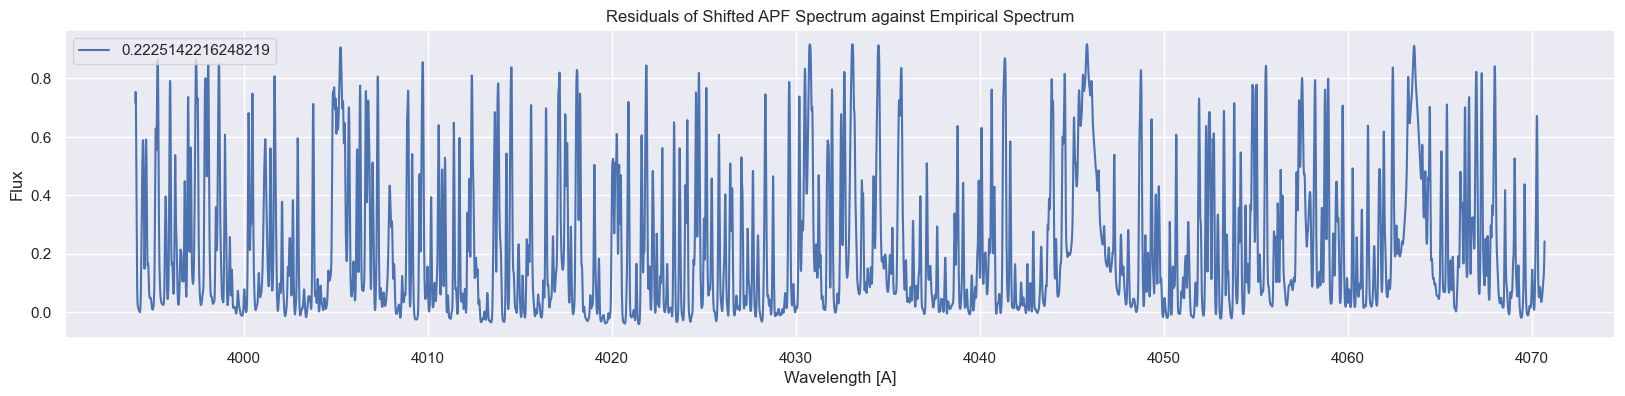

The average residual is 0.2225142216248219


In [125]:
residuals(12)

In [128]:
def plot_shifted_spectrum(order = 0):
    wl_syn, fl_syn = solar_log_scale(order)
    wl2, flux2 = wavelength_log_scale(order)
    index = finding_velocity_shift(order)
    shift, shift_dir = chi_squared_test(order)
    wl_syn_plot, fl_syn_plot = shifted_vs_not_plot(order)
    shifted_wl, shifted_fl = shifted_vs_not(order)
    
    
    plt.figure(figsize = (16,4))
    plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
    plt.plot(shifted_wl, shifted_fl, label = 'Shifted APF Spectrum')

    plt.title('Shifted Spectrum')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.legend()
    plt.show()

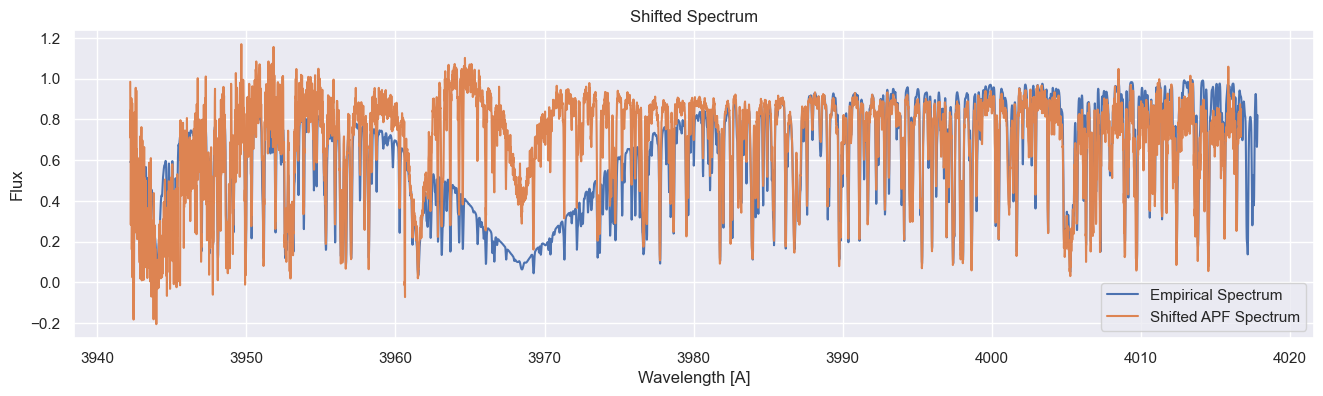

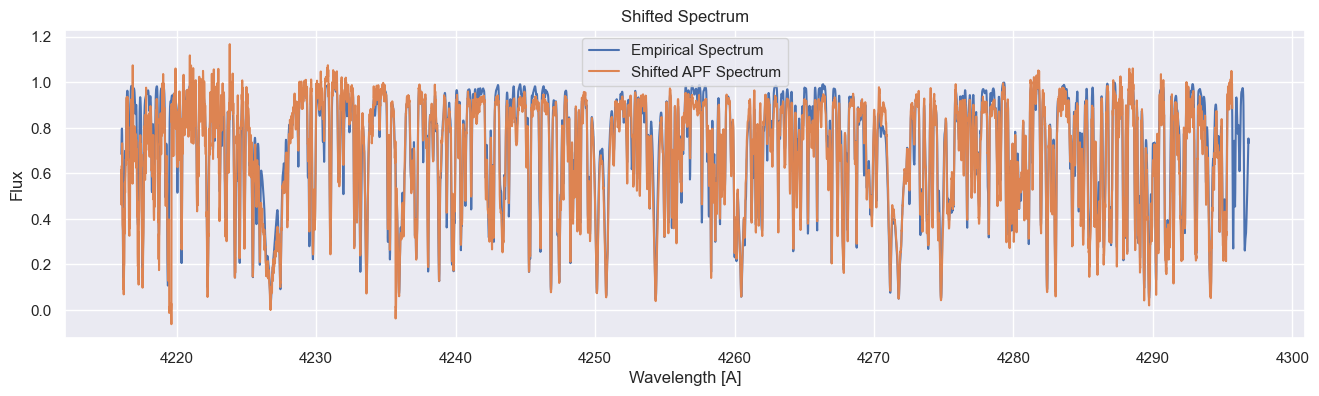

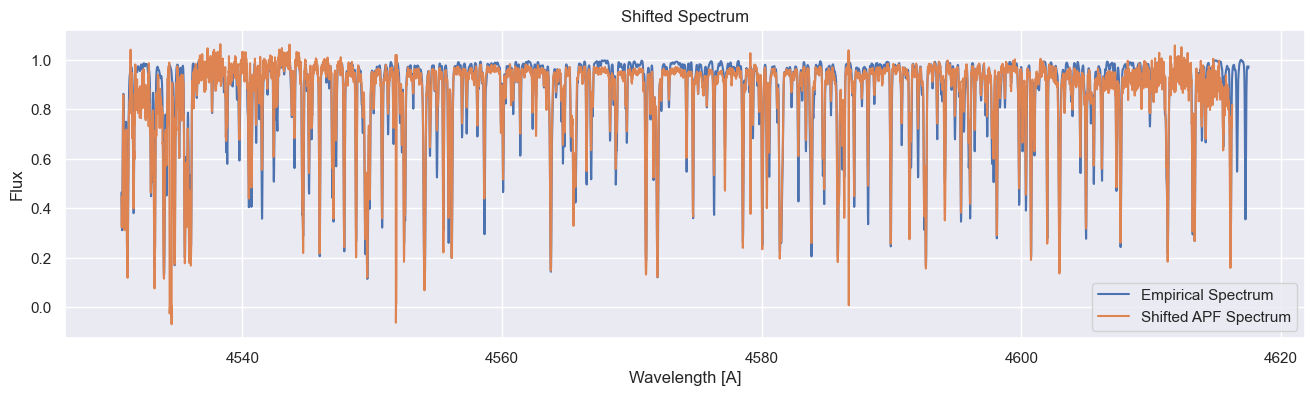

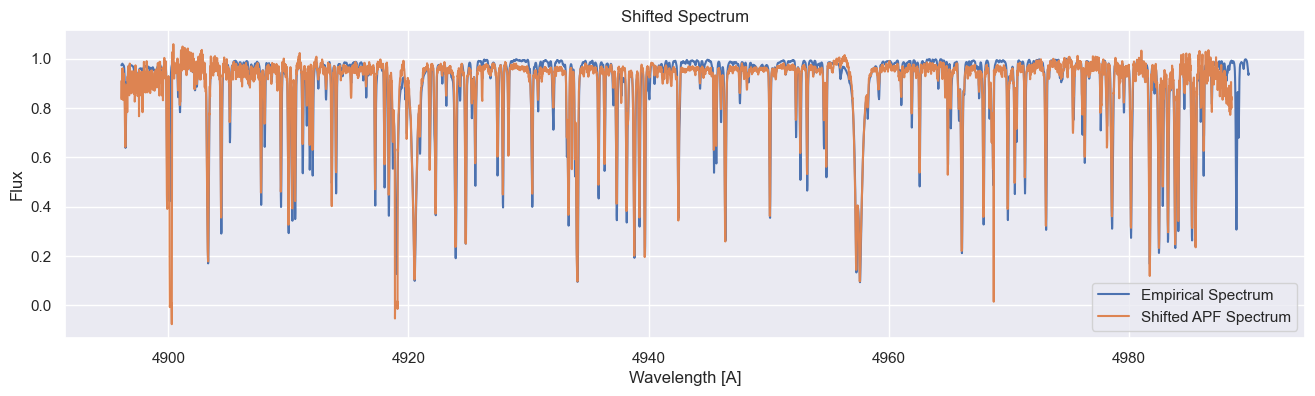

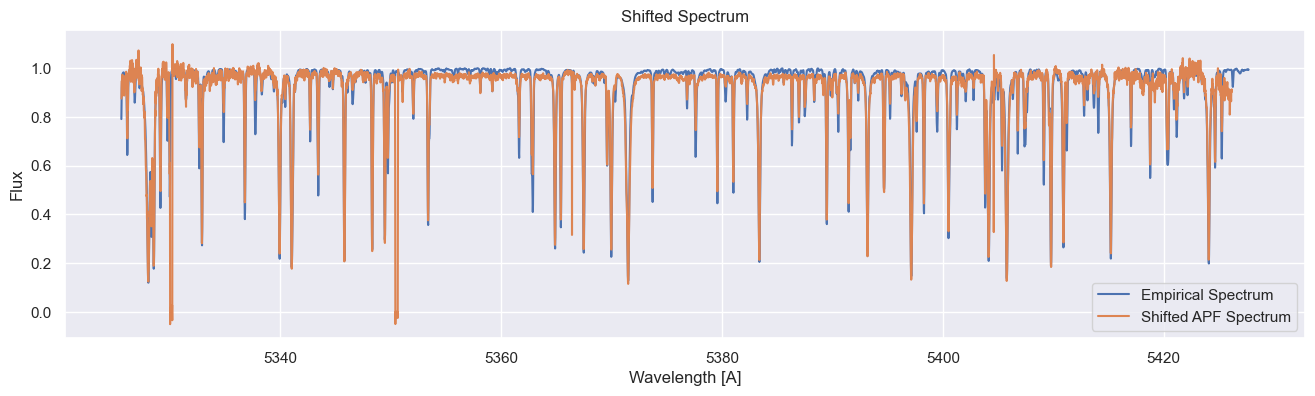

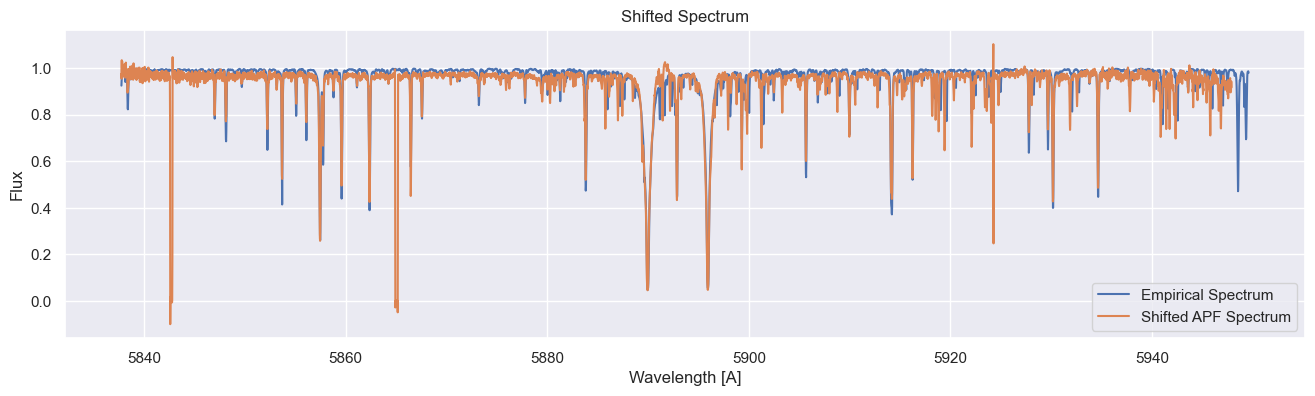

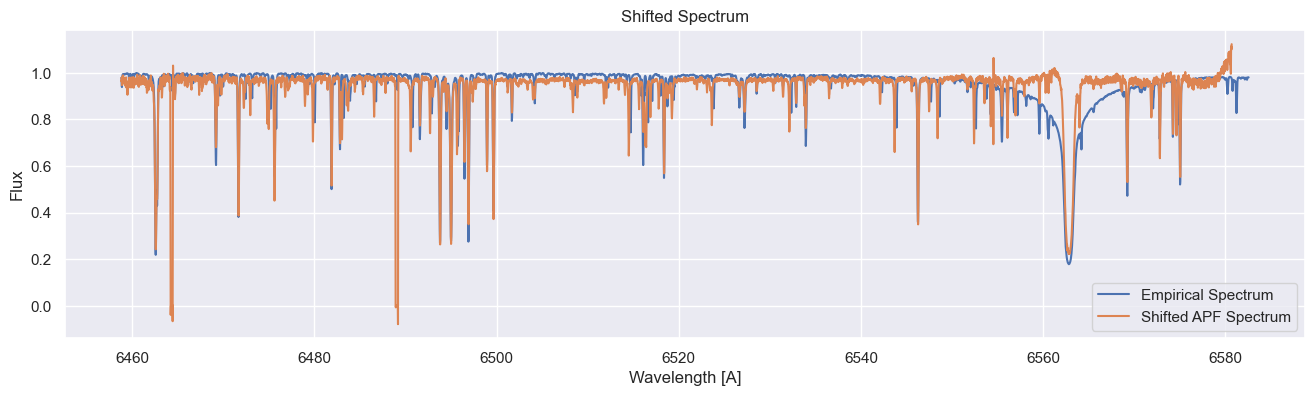

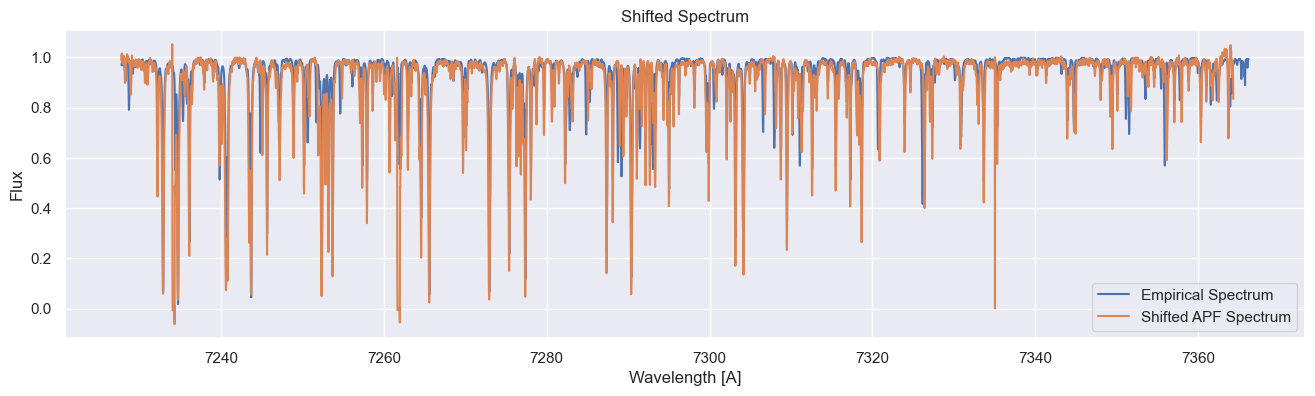

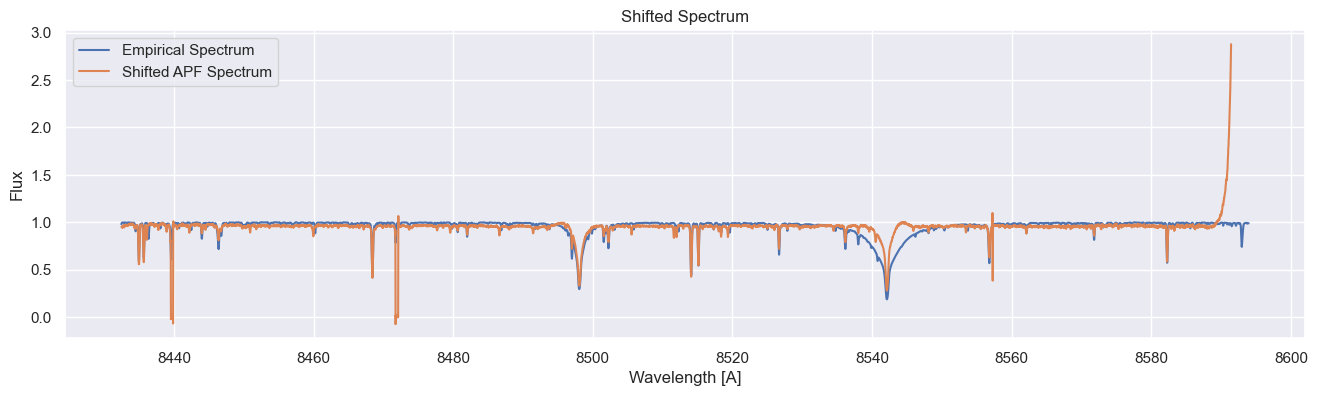

In [130]:
for i in range(10,100,10):
    plot_shifted_spectrum(i)

_The first one looks kind of jank, so I'll have to see whats causing that issue -- probably has to do with the normalization since there is such a dramatic drop in the middle area that might be harder to normalize (order = 10)_

_I've also noticed that some seem to get cut-off at the end. . . idk whats causing that yet_

In [134]:
def shifted_residuals(order = 0):
    wl_syn, fl_syn = solar_log_scale(order)
    wl2, flux2 = wavelength_log_scale(order)
    index = finding_velocity_shift(order)
    shift, shift_dir = chi_squared_test(order)
    wl_syn_plot, fl_syn_plot = shifted_vs_not_plot(order)
    shifted_wl, shifted_fl = shifted_vs_not(order)
    residuals_shifted = shifted_fl - fl_syn_plot[:len(shifted_wl)]
    plt.figure(figsize = (20,4))
    plt.plot(wl_syn_plot[:len(shifted_wl)], residuals_shifted)

    plt.title('Residuals of Shifted APF Spectrum against Empirical Spectrum')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.show()

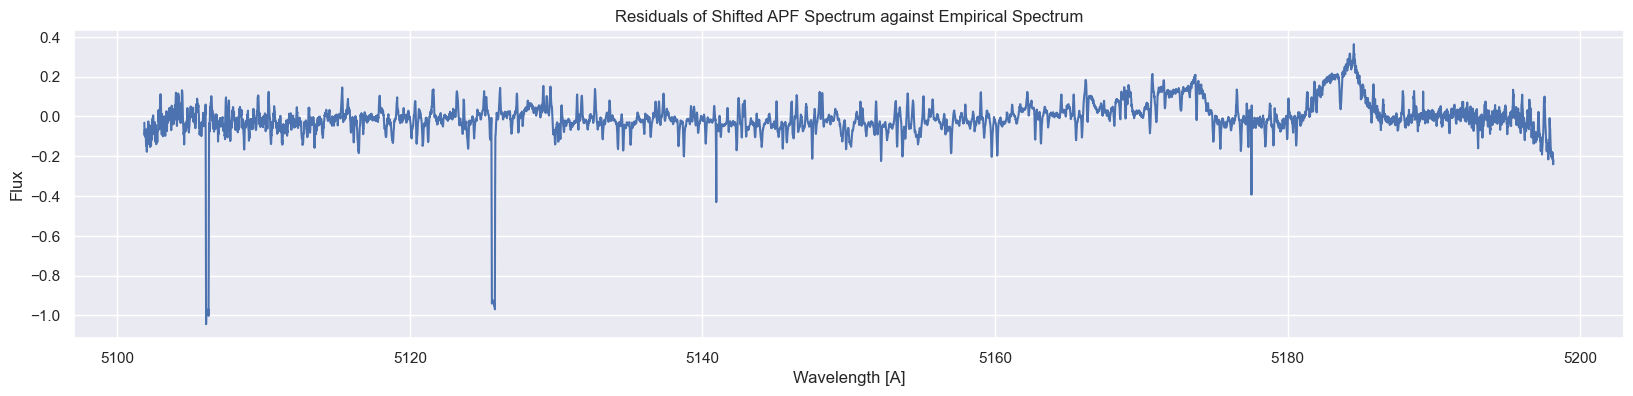

In [135]:
shifted_residuals(45)

## Final Plots

In [137]:
def final_plot(order = 0):
    wl_syn, fl_syn = solar_log_scale(order)
    wl2, flux2 = wavelength_log_scale(order)
    index = finding_velocity_shift(order)
    shift, shift_dir = chi_squared_test(order)
    shifted_wl, shifted_fl = shifted_vs_not(order)
    plt.figure(figsize = (10,3))
    plt.plot(shifted_wl, shifted_fl)
    plt.title('Final Reduced APF Spectrum for ' + star + ': Order ' + str(order))
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux')
    plt.show()

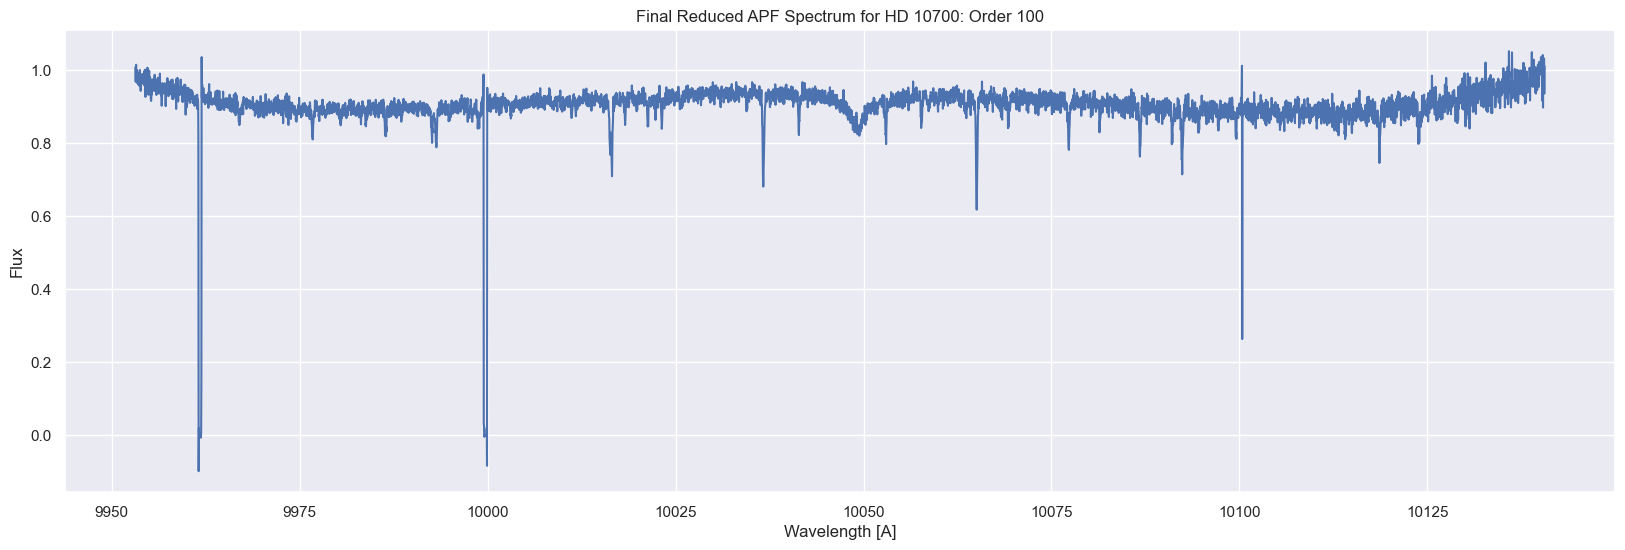

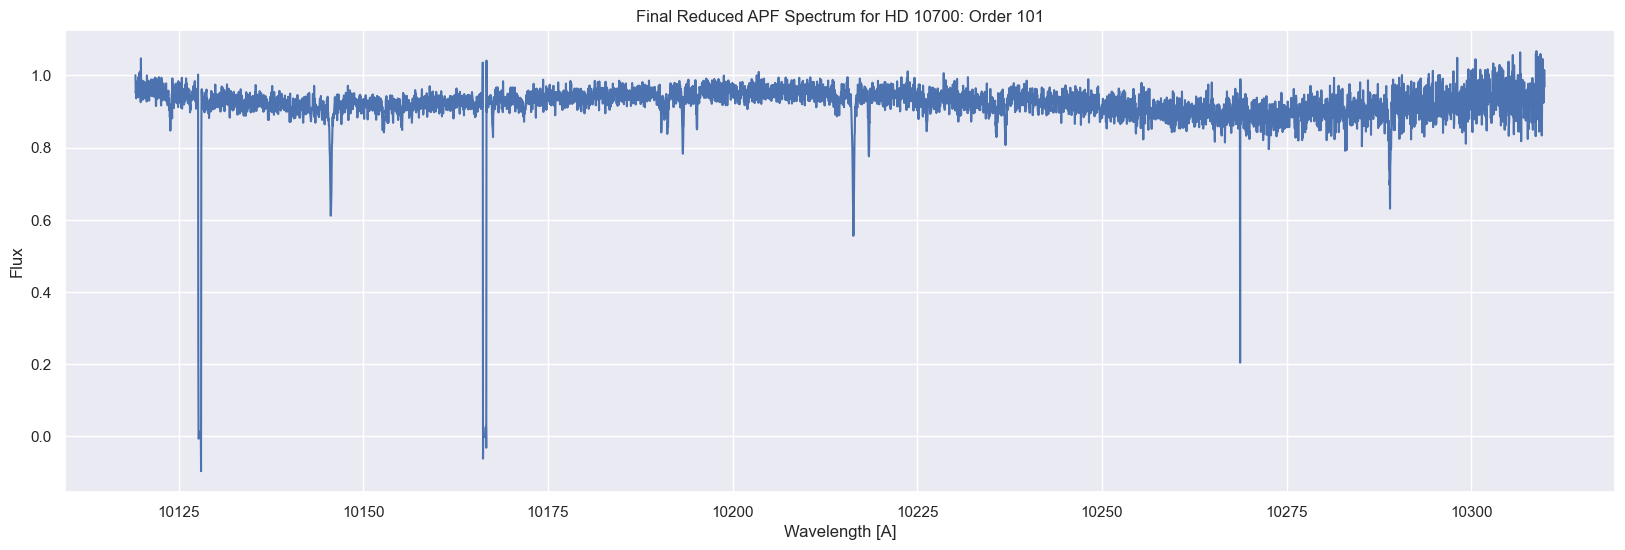

KeyboardInterrupt: 

In [142]:
# for i in range(100,130,1):
#     final_plot(i)

In [141]:
#orders that aren't good enough to keep: 
bad_orders = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12, 95, 96])

In [140]:
def table_making(order):
    ''' returns the final shifted spectrum to be fit to gaussians'''
    '''still need to figure out which of these functions are necessary or not'''
    wl_syn, fl_syn = solar_log_scale(order)
    wl2, flux2 = wavelength_log_scale(order)
    index = finding_velocity_shift(order)
    shift, shift_dir = chi_squared_test(order)
    wl_syn_plot, fl_syn_plot = shifted_vs_not_plot(order)
    
    shifted_wl, shifted_fl = shifted_vs_not(order)
    
    return shifted_wl, shifted_fl 

In [148]:
shifted_wls = []
shifted_fls = []

for i in range(13,95, 1):
    shifted_wl, shifted_fl = table_making(i)
    shifted_wls.append(shifted_wl)
    shifted_fls.append(shifted_fl)
    

KeyboardInterrupt: 

In [150]:
shifted_wls, shifted_fls

([array([4020.56610385, 4020.57951501, 4020.59292622, ..., 4096.51097249,
         4096.52463698, 4096.53830151]),
  array([4047.36164688, 4047.37514743, 4047.38864802, ..., 4123.81265917,
         4123.82641473, 4123.84017034]),
  array([4074.54993908, 4074.56353032, 4074.5771216 , ..., 4151.5145137 ,
         4151.52836166, 4151.54220967]),
  array([4102.07150221, 4102.08518524, 4102.09886833, ..., 4179.55593433,
         4179.56987583, 4179.58381738]),
  array([4129.96984742, 4129.98362352, 4129.99739966, ..., 4207.98125414,
         4207.99529045, 4208.00932682]),
  array([4158.26177941, 4158.27564987, 4158.28952039, ..., 4236.79346279,
         4236.80759521, 4236.82172768]),
  array([4186.93910812, 4186.95307425, 4186.96704042, ..., 4266.02661281,
         4266.04084274, 4266.05507272]),
  array([4216.03231423, 4216.0463774 , 4216.06044062, ..., 4295.65503459,
         4295.66936335, 4295.68369216]),
  array([4245.49682641, 4245.51098786, 4245.52514936, ..., 4325.6904336 ,
      

In [151]:
#adding them to a libary to be exported
import pandas as pd

In [153]:
data_2darray = {'shifted wavelengths':shifted_wls, 'shifted fluxs': shifted_fls}
data_set = pd.DataFrame(data_2darray)

data_set

,shifted wavelengths,shifted fluxs
0,"[4020.5661038455896, 4020.5795150105346, 4020....","[0.620223885293999, 0.6059488760975837, 0.5892..."
1,"[4047.3616468838295, 4047.3751474290852, 4047....","[0.7052560336635326, 0.5383919415399959, 0.596..."
2,"[4074.549939082961, 4074.5635303185973, 4074.5...","[0.9426674457230896, 0.8392360441974884, 0.695..."
3,"[4102.071502205299, 4102.085185242989, 4102.09...","[0.25037036801078216, 0.5092470259486737, 0.26..."
4,"[4129.969847423744, 4129.9836235202965, 4129.9...","[0.551371168300889, 0.47534295833149354, 0.445..."
5,"[4158.261779405831, 4158.27564987411, 4158.289...","[0.7502520629876616, 0.6892125223024939, 0.586..."
6,"[4186.939108123032, 4186.953074248584, 4186.96...","[0.41085532180985646, 0.5346615547259137, 0.24..."
7,"[4216.032314232375, 4216.046377402416, 4216.06...","[0.6151750281194082, 0.46116815061434896, 0.63..."
8,"[4245.496826410313, 4245.5109878633875, 4245.5...","[0.7687012637514836, 0.8804502729175134, 0.825..."
9,"[4275.411921698852, 4275.426182937944, 4275.44...","[0.47070426964419343, 0.4127628872746776, 0.59..."


In [156]:
#hopefully it exports
data_set.to_csv("C:\\Users\\alica\\workspace\\Intro-2-Spectra\\analysis\\NEID_analysis\\alpha_tau_ceti_shifted_values.csv")
